In [1]:
import argparse
import os
import sys
import random
import time
import re
from dataclasses import dataclass
from distutils.util import strtobool
from typing import Any, List, Optional, Union, Tuple, Iterable
import gym
import numpy as np
import torch
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from einops import rearrange
from gym.spaces import Discrete, Box
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from numpy.random import Generator
import gym.envs.registration
import pandas as pd
import utils

MAIN = __name__ == "__main__"
os.environ["SDL_VIDEODRIVER"] = "dummy"

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/tensorboard/compat/proto/histogram_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
/Users/jon/ml/arena/venv/lib/python3.9/site-packages/tensorboard/compat/proto/histogram_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
/Users/jon/ml/arena/venv/lib/python3.9/site-packages/tensorboard/compat/proto/histogram_pb2.py:29: DeprecationWarning: Call to deprecated create function Descriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  

In [2]:
from collections import OrderedDict

class QNetwork(nn.Module):
    def __init__(self, dim_observation: int, num_actions: int, hidden_sizes: list[int] = [120, 84]):
        super().__init__()
        h1, h2 = hidden_sizes
        self.model = nn.Sequential(OrderedDict([
            ('lin1', nn.Linear(dim_observation, h1)),
            ("relu1", nn.ReLU()),
            ("lin2", nn.Linear(h1, h2)),
            ("relu2", nn.ReLU()),
            ("lin3", nn.Linear(h2, num_actions))
        ])).type(t.float32)
        
    def forward(self, x: t.Tensor) -> t.Tensor:
        return self.model(x)

if MAIN:
    net = QNetwork(dim_observation=4, num_actions=2) # no put in?
    n_params = sum((p.nelement() for p in net.parameters()))
    print(net)
    print(f"Total number of parameters: {n_params}")
    print("You should manually verify network is Linear-ReLU-Linear-ReLU-Linear")
    assert n_params == 10934

QNetwork(
  (model): Sequential(
    (lin1): Linear(in_features=4, out_features=120, bias=True)
    (relu1): ReLU()
    (lin2): Linear(in_features=120, out_features=84, bias=True)
    (relu2): ReLU()
    (lin3): Linear(in_features=84, out_features=2, bias=True)
  )
)
Total number of parameters: 10934
You should manually verify network is Linear-ReLU-Linear-ReLU-Linear


In [3]:
@dataclass
class ReplayBufferSamples:
    '''
    Samples from the replay buffer, converted to PyTorch for use in neural network training.
    obs: shape (sample_size, *observation_shape), dtype t.float
    actions: shape (sample_size, ) dtype t.int
    rewards: shape (sample_size, ), dtype t.float
    dones: shape (sample_size, ), dtype t.bool
    next_observations: shape (sample_size, *observation_shape), dtype t.float
    '''

    observations: t.Tensor
    actions: t.Tensor
    rewards: t.Tensor
    dones: t.Tensor
    next_observations: t.Tensor


class ReplayBuffer:
    rng: Generator
    observations: t.Tensor
    actions: t.Tensor
    rewards: t.Tensor
    dones: t.Tensor
    next_observations: t.Tensor

    def __init__(self, buffer_size: int, num_actions: int, observation_shape: tuple, num_environments: int, seed: int):
        assert num_environments == 1, "This buffer only supports SyncVectorEnv with 1 environment inside."
        #Implement ReplayBuffer. It only needs to handle a discrete action space, and you can assume 
        #observations are some shape of dtype np.float32, and actions are of dtype np.int64. The replay buffer will store experiences
        #in a circular queue. If the buffer is already full, the oldest experience is overwritten

        self.rng = np.random.default_rng(seed)
        self.buffer_size = buffer_size
        self.observation_shape = observation_shape
        self.observations = t.zeros((buffer_size,) + observation_shape)
        self.actions = t.zeros((buffer_size, ), dtype=t.int64)
        self.rewards = t.zeros((buffer_size, ))
        self.dones = t.zeros(buffer_size)
        self.next_observations = t.zeros((buffer_size, *observation_shape))
        self.towrite = 0
        self.currsize = 0


    def add(
        self, obs: np.ndarray, actions: np.ndarray, rewards: np.ndarray, dones: np.ndarray, next_obs: np.ndarray
    ) -> None:
        '''
        obs: shape (num_environments, *observation_shape) 
            Observation before the action
        actions: shape (num_environments, ) 
            Action chosen by the agent
        rewards: shape (num_environments, )
            Reward after the action
        dones: shape (num_environments, ) 
            If True, the episode ended and was reset automatically
        next_obs: shape (num_environments, *observation_shape) 
            Observation after the action
            If done is True, this should be the terminal observation, NOT the first  observation of the next episode.
        '''
        if self.towrite > self.currsize:
            self.written = 0
        self.observations[self.towrite] = t.from_numpy(obs)
        self.actions[self.towrite] = t.as_tensor(actions)
        self.rewards[self.towrite] = t.as_tensor(rewards)
        self.dones[self.towrite] = t.as_tensor(dones)
        self.next_observations[self.towrite] = t.as_tensor(next_obs)
        self.currsize = min(self.currsize + 1, self.buffer_size)
        self.towrite = (self.towrite + 1) % self.buffer_size

    def sample(self, sample_size: int, device: t.device) -> ReplayBufferSamples:
        '''Uniformly sample sample_size entries from the buffer and convert them to PyTorch tensors on device.
        Sampling is with replacement, and sample_size may be larger than the buffer size.
        '''
        idx = self.rng.integers(0, self.currsize, size=sample_size)
        obs = self.observations[idx]
        actions = self.actions[idx]
        rewards = self.rewards[idx]
        dones = self.dones[idx]
        next_obs = self.next_observations[idx]
        # print(ReplayBufferSamples(obs, actions, rewards, dones, next_obs))
        return ReplayBufferSamples(obs, actions, rewards, dones, next_obs)

# if MAIN:
#     utils.test_replay_buffer_single(ReplayBuffer)
#     utils.test_replay_buffer_deterministic(ReplayBuffer)
#     utils.test_replay_buffer_wraparound(ReplayBuffer)

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


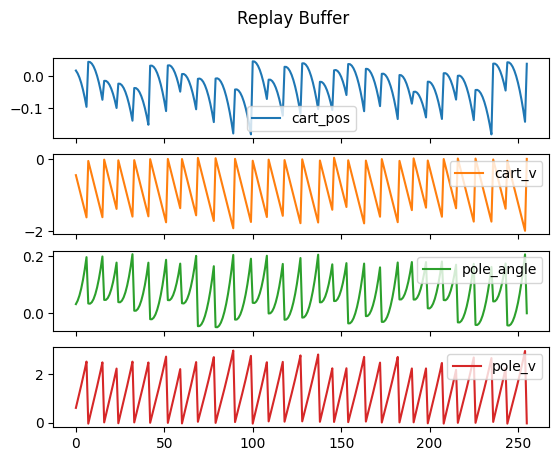

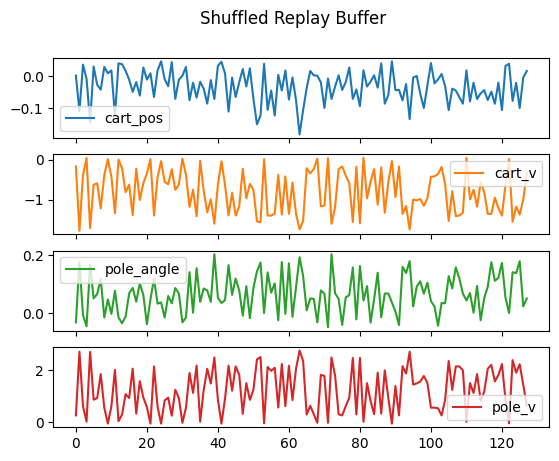

In [4]:
if MAIN:
    rb = ReplayBuffer(buffer_size=256, num_actions=2, observation_shape=(4,), num_environments=1, seed=0)
    envs = gym.vector.SyncVectorEnv([utils.make_env("CartPole-v1", 0, 0, False, "test")])
    obs = envs.reset()
    for i in range(512):
        actions = np.array([0])
        (next_obs, rewards, dones, infos) = envs.step(actions)
        real_next_obs = next_obs.copy()
        for (i, done) in enumerate(dones):
            if done:
                real_next_obs[i] = infos[i]["terminal_observation"]
        rb.add(obs, actions, rewards, dones, next_obs)
        obs = next_obs
    sample = rb.sample(128, t.device("cpu"))
    columns = ["cart_pos", "cart_v", "pole_angle", "pole_v"]
    df = pd.DataFrame(rb.observations, columns=columns)
    df.plot(subplots=True, title="Replay Buffer")
    df2 = pd.DataFrame(sample.observations, columns=columns)
    df2.plot(subplots=True, title="Shuffled Replay Buffer")

In [5]:
def linear_schedule(
    current_step: int, start_e: float, end_e: float, exploration_fraction: float, total_timesteps: int
) -> float:
    '''Return the appropriate epsilon for the current step.

    Epsilon should be start_e at step 0 and decrease linearly to end_e at step (exploration_fraction * total_timesteps).

    It should stay at end_e for the rest of the episode.
    '''
    if current_step < exploration_fraction * total_timesteps:
        return start_e - (start_e - end_e) * current_step / (exploration_fraction * total_timesteps)
    else:
        return end_e

if MAIN:
    epsilons = [
        linear_schedule(step, start_e=1.0, end_e=0.05, exploration_fraction=0.5, total_timesteps=500)
        for step in range(500)
    ]
    utils.test_linear_schedule(linear_schedule)

In [6]:
def epsilon_greedy_policy(
    envs: gym.vector.SyncVectorEnv, q_network: QNetwork, rng: Generator, obs: t.Tensor, epsilon: float
) -> np.ndarray:
    '''With probability epsilon, take a random action. Otherwise, take a greedy action according to the q_network.
    Inputs:
        envs : gym.vector.SyncVectorEnv, the family of environments to run against
        q_network : QNetwork, the network used to approximate the Q-value function
        obs : The current observation
        epsilon : exploration percentage
    Outputs:
        actions: (n_environments, ) the sampled action for each environment.
    '''
    if rng.random() < epsilon:
        return np.array(rng.integers(0, envs.single_action_space.n, (envs.action_space.shape[0])))
    else:
        return q_network(obs).argmax(dim=-1).cpu().numpy()

if MAIN:
    utils.test_epsilon_greedy_policy(epsilon_greedy_policy)

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


In [7]:
ObsType = np.ndarray
ActType = int

class Probe1(gym.Env):
    '''One action, observation of [0.0], one timestep long, +1 reward.

    We expect the agent to rapidly learn that the value of the constant [0.0] observation is +1.0. Note we're using a continuous observation space for consistency with CartPole.
    '''

    action_space: Discrete
    observation_space: Box

    def __init__(self):
        super().__init__()
        self.observation_space = Box(np.array([0]), np.array([0]))
        self.action_space = Discrete(1)
        self.seed()
        self.reset()

    def step(self, action: ActType) -> tuple[ObsType, float, bool, dict]:
        return (np.array([0]), 1.0, True, {})

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        if return_info:
            return (np.array([0.0]), {})
        return np.array([0.0])

gym.envs.registration.register(id="Probe1-v0", entry_point=Probe1)
if MAIN:
    env = gym.make("Probe1-v0")
    assert env.observation_space.shape == (1,)
    assert env.action_space.shape == ()

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment Probe1-v0
  logger.warn(f"Overriding environment {id}")
/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [8]:
class Probe2(gym.Env):
    '''One action, observation of [-1.0] or [+1.0], one timestep long, reward equals observation.

    We expect the agent to rapidly learn the value of each observation is equal to the observation.
    '''

    action_space: Discrete
    observation_space: Box

    def __init__(self):
        pass

    def step(self, action: ActType) -> tuple[ObsType, float, bool, dict]:
        pass

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        pass

gym.envs.registration.register(id="Probe2-v0", entry_point=Probe2)

class Probe3(gym.Env):
    '''One action, [0.0] then [1.0] observation, two timesteps, +1 reward at the end.

    We expect the agent to rapidly learn the discounted value of the initial observation.
    '''

    action_space: Discrete
    observation_space: Box

    def __init__(self):
        pass

    def step(self, action: ActType) -> tuple[ObsType, float, bool, dict]:
        pass

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        pass

gym.envs.registration.register(id="Probe3-v0", entry_point=Probe3)

class Probe4(gym.Env):
    '''Two actions, [0.0] observation, one timestep, reward is -1.0 or +1.0 dependent on the action.

    We expect the agent to learn to choose the +1.0 action.
    '''

    action_space: Discrete
    observation_space: Box

    def __init__(self):
        pass

    def step(self, action: ActType) -> tuple[ObsType, float, bool, dict]:
        pass

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        pass

gym.envs.registration.register(id="Probe4-v0", entry_point=Probe4)

class Probe5(gym.Env):
    '''Two actions, random 0/1 observation, one timestep, reward is 1 if action equals observation otherwise -1.

    We expect the agent to learn to match its action to the observation.
    '''

    action_space: Discrete
    observation_space: Box

    def __init__(self):
        pass

    def step(self, action: ActType) -> tuple[ObsType, float, bool, dict]:
        pass

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        pass

gym.envs.registration.register(id="Probe5-v0", entry_point=Probe5)

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment Probe2-v0
  logger.warn(f"Overriding environment {id}")
/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment Probe3-v0
  logger.warn(f"Overriding environment {id}")
/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment Probe4-v0
  logger.warn(f"Overriding environment {id}")
/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment Probe5-v0
  logger.warn(f"Overriding environment {id}")


In [9]:
@dataclass
class DQNArgs:
    exp_name: str = os.path.basename(globals().get("__file__", "DQN_implementation").rstrip(".py"))
    seed: int = 1
    torch_deterministic: bool = True
    cuda: bool = True
    track: bool = False
    wandb_project_name: str = "CartPoleDQN"
    wandb_entity: Optional[str] = None
    capture_video: bool = False
    env_id: str = "CartPole-v1"
    total_timesteps: int = 500000
    learning_rate: float = 0.00025
    buffer_size: int = 10000
    gamma: float = 0.99
    target_network_frequency: int = 500
    batch_size: int = 128
    start_e: float = 1.0
    end_e: float = 0.05
    exploration_fraction: float = 0.5
    learning_starts: int = 10000
    train_frequency: int = 10

arg_help_strings = dict(
    exp_name = "the name of this experiment",
    seed = "seed of the experiment",
    torch_deterministic = "if toggled, `torch.backends.cudnn.deterministic=False`",
    cuda = "if toggled, cuda will be enabled by default",
    track = "if toggled, this experiment will be tracked with Weights and Biases",
    wandb_project_name = "the wandb's project name",
    wandb_entity = "the entity (team) of wandb's project",
    capture_video = "whether to capture videos of the agent performances (check out `videos` folder)",
    env_id = "the id of the environment",
    total_timesteps = "total timesteps of the experiments",
    learning_rate = "the learning rate of the optimizer",
    buffer_size = "the replay memory buffer size",
    gamma = "the discount factor gamma",
    target_network_frequency = "the timesteps it takes to update the target network",
    batch_size = "the batch size of samples from the replay memory",
    start_e = "the starting epsilon for exploration",
    end_e = "the ending epsilon for exploration",
    exploration_fraction = "the fraction of `total-timesteps` it takes from start-e to go end-e",
    learning_starts = "timestep to start learning",
    train_frequency = "the frequency of training",
)
toggles = ["torch_deterministic", "cuda", "track", "capture_video"]

def parse_args(arg_help_strings=arg_help_strings, toggles=toggles) -> DQNArgs:
    parser = argparse.ArgumentParser()
    for (name, field) in DQNArgs.__dataclass_fields__.items():
        flag = "--" + name.replace("_", "-")
        type_function = field.type if field.type != bool else lambda x: bool(strtobool(x))
        toggle_kwargs = {"nargs": "?", "const": True} if name in toggles else {}
        parser.add_argument(
            flag, type=type_function, default=field.default, help=arg_help_strings[name], **toggle_kwargs
        )
    return DQNArgs(**vars(parser.parse_args()))

def setup(args: DQNArgs) -> Tuple[str, SummaryWriter, np.random.Generator, t.device, gym.vector.SyncVectorEnv]:
    '''Helper function to set up useful variables for the DQN implementation'''
    run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
    if args.track:
        import wandb

        wandb.init(
            project=args.wandb_project_name,
            entity=args.wandb_entity,
            sync_tensorboard=True,
            config=vars(args),
            name=run_name,
            monitor_gym=True,
            save_code=True,
        )
    writer = SummaryWriter(f"runs/{run_name}")
    writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s" % "\n".join([f"|{key}|{value}|" for (key, value) in vars(args).items()]),
    )
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = args.torch_deterministic
    rng = np.random.default_rng(args.seed)
    device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
    envs = gym.vector.SyncVectorEnv([utils.make_env(args.env_id, args.seed, 0, args.capture_video, run_name)])
    assert isinstance(envs.single_action_space, Discrete), "only discrete action space is supported"
    return (run_name, writer, rng, device, envs)

def log(
    writer: SummaryWriter,
    start_time: float,
    step: int,
    predicted_q_vals: t.Tensor,
    loss: Union[float, t.Tensor],
    infos: Iterable[dict],
    epsilon: float,
):
    '''Helper function to write relevant info to TensorBoard logs, and print some things to stdout'''
    if step % 100 == 0:
        writer.add_scalar("losses/td_loss", loss, step)
        writer.add_scalar("losses/q_values", predicted_q_vals.mean().item(), step)
        writer.add_scalar("charts/SPS", int(step / (time.time() - start_time)), step)
        if step % 10000 == 0:
            print("SPS:", int(step / (time.time() - start_time)))
    for info in infos:
        if "episode" in info.keys():
            print(f"global_step={step}, episodic_return={info['episode']['r']}")
            writer.add_scalar("charts/episodic_return", info["episode"]["r"], step)
            writer.add_scalar("charts/episodic_length", info["episode"]["l"], step)
            writer.add_scalar("charts/epsilon", epsilon, step)
            break

In [10]:
import copy
t.set_default_dtype(t.float32)
def train_dqn(args: DQNArgs):
    (run_name, writer, rng, device, envs) = setup(args)
    "YOUR CODE: Create your Q-network, Adam optimizer, and replay buffer here."

    q_network = QNetwork(envs.single_observation_space.shape[0], envs.single_action_space.n).to(device)
    t_network = copy.deepcopy(q_network).to(device)
    optimizer = optim.Adam(q_network.parameters(), lr=args.learning_rate)
    rb = ReplayBuffer(args.buffer_size, envs.single_action_space.n, envs.single_observation_space.shape, envs.num_envs, args.seed)

    start_time = time.time()
    obs = envs.reset()
    for step in range(args.total_timesteps):
        "YOUR CODE: Sample actions according to the epsilon greedy policy using the linear schedule for epsilon, and then step the environment"
        "Boilerplate to handle the terminal observation case"

        epsilon = linear_schedule(step, args.start_e, args.end_e, args.exploration_fraction, args.total_timesteps)
        # ACTION PHASE
        actions = epsilon_greedy_policy(envs, q_network, rng, t.Tensor(obs).to(device), epsilon)
        next_obs, rewards, dones, infos = envs.step(actions)
        real_next_obs = next_obs.copy()
        for (i, done) in enumerate(dones):
            if done:
                real_next_obs[i] = infos[i]["terminal_observation"]
        rb.add(obs, actions, rewards, dones, next_obs)
        obs = next_obs

        # LEARNING PHASE
        if step > args.learning_starts and step % args.train_frequency == 0:
            "YOUR CODE: Sample from the replay buffer"
            samples = rb.sample(args.batch_size, device)
            # compute the TD target
            "YOUR CODE: Compute the TD target using the target network"
            with torch.no_grad():
                q_next = t_network(samples.next_observations).max(dim=1).values
                q_target = samples.rewards.flatten() + args.gamma * q_next * (1 - samples.dones.flatten()) # target network reward estimate at t+1

            gather_arg = rearrange(sample.actions, "a -> a 1")
            predicted_q_vals = q_network(sample.observations).gather(1, gather_arg).squeeze() # q-network reward estimate

            # compute the loss
            loss = F.mse_loss(predicted_q_vals, q_target)
            # update the network
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if step % args.target_network_frequency == 0:
                t_network = copy.deepcopy(q_network).to(device)


            log(writer, start_time, step, predicted_q_vals, loss, infos, epsilon)

    "If running one of the Probe environments, will test if the learned q-values are\n    sensible after training. Useful for debugging."
    probe_batches = [
        t.tensor([[0.0]]), t.tensor([[-1.0], [+1.0]]), t.tensor([[0.0], [1.0]]), t.tensor([[0.0]]), t.tensor([[0.0], [1.0]])
    ]
    if re.match(r"Probe(\d)-v0", args.env_id):
        probe_no = int(re.match(r"Probe(\d)-v0", args.env_id).group(1))
        batch = probe_batches[probe_no]
        value = q_network(batch)
        print("Value: ", value)
        expected = t.tensor([[1.0]]).to(device)
        t.testing.assert_close(value, expected, 0.0001)

    envs.close()
    writer.close()

In [11]:
if MAIN:
    if "ipykernel_launcher" in os.path.basename(sys.argv[0]):
        filename = globals().get("__file__", "<filename of this script>")
        print(f"Try running this file from the command line instead: python {os.path.basename(filename)} --help")
        args = DQNArgs(track=True, capture_video=True)
    else:
        args = parse_args()
    train_dqn(args)

Try running this file from the command line instead: python <filename of this script> --help


wandb: Currently logged in as: jnhl. Use `wandb login --relogin` to force relogin
/Users/jon/ml/arena/venv/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/Users/jon/ml/arena/venv/lib/python3.9/site-packages/wandb/sdk/lib/import_hooks.py:246: DeprecationWarning: Deprecated since Python 3.4. Use importlib.util.find_spec() instead.
  loader = importlib.find_loader(fullname, path)
/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(
/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be repl

global_step=10280, episodic_return=14.0
global_step=10490, episodic_return=14.0
global_step=11090, episodic_return=25.0
global_step=11310, episodic_return=11.0


/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=11810, episodic_return=14.0
global_step=12230, episodic_return=23.0
global_step=12410, episodic_return=19.0
global_step=12470, episodic_return=21.0
global_step=12490, episodic_return=20.0
global_step=12530, episodic_return=15.0
global_step=12870, episodic_return=21.0
global_step=13120, episodic_return=13.0
global_step=13220, episodic_return=45.0
global_step=13360, episodic_return=12.0
global_step=13740, episodic_return=15.0
global_step=13790, episodic_return=13.0
global_step=13910, episodic_return=15.0
global_step=13980, episodic_return=34.0
global_step=14220, episodic_return=12.0
global_step=14430, episodic_return=18.0
global_step=14590, episodic_return=21.0
global_step=14600, episodic_return=10.0
global_step=14620, episodic_return=20.0
global_step=15200, episodic_return=14.0
global_step=15210, episodic_return=10.0
global_step=15430, episodic_return=12.0
global_step=15920, episodic_return=15.0
global_step=16210, episodic_return=23.0
global_step=16280, episodic_return=21.0


/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=16500, episodic_return=24.0
global_step=16650, episodic_return=18.0
global_step=17230, episodic_return=11.0
global_step=17250, episodic_return=20.0
global_step=17330, episodic_return=69.0
global_step=18200, episodic_return=14.0
global_step=18360, episodic_return=11.0
global_step=18400, episodic_return=26.0
global_step=19360, episodic_return=16.0
global_step=19640, episodic_return=11.0
global_step=19680, episodic_return=12.0
global_step=19940, episodic_return=35.0
SPS: 2934
global_step=20220, episodic_return=32.0
global_step=20290, episodic_return=22.0
global_step=20590, episodic_return=25.0
global_step=21390, episodic_return=37.0
global_step=21680, episodic_return=102.0
global_step=21750, episodic_return=25.0
global_step=21930, episodic_return=14.0
global_step=22000, episodic_return=29.0
global_step=22460, episodic_return=17.0
global_step=22490, episodic_return=16.0


/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=22760, episodic_return=11.0
global_step=23110, episodic_return=39.0
global_step=23470, episodic_return=27.0
global_step=23550, episodic_return=11.0
global_step=23710, episodic_return=18.0
global_step=24170, episodic_return=19.0
global_step=24430, episodic_return=17.0
global_step=24540, episodic_return=14.0
global_step=24550, episodic_return=10.0
global_step=24880, episodic_return=13.0
global_step=24980, episodic_return=26.0
global_step=25010, episodic_return=19.0
global_step=25320, episodic_return=13.0
global_step=25440, episodic_return=22.0
global_step=25460, episodic_return=20.0
global_step=25550, episodic_return=48.0
global_step=25720, episodic_return=14.0
global_step=26090, episodic_return=14.0
global_step=26180, episodic_return=22.0
global_step=26510, episodic_return=26.0
global_step=26710, episodic_return=9.0
global_step=26750, episodic_return=15.0
global_step=26860, episodic_return=18.0
global_step=26960, episodic_return=13.0
global_step=27020, episodic_return=9.0
gl

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=43820, episodic_return=15.0
global_step=44350, episodic_return=13.0
global_step=44680, episodic_return=24.0
global_step=44720, episodic_return=13.0
global_step=44740, episodic_return=20.0
global_step=44770, episodic_return=11.0
global_step=45000, episodic_return=21.0
global_step=45090, episodic_return=15.0
global_step=45150, episodic_return=23.0
global_step=45540, episodic_return=9.0
global_step=45690, episodic_return=17.0
global_step=45970, episodic_return=54.0
global_step=46230, episodic_return=15.0
global_step=46320, episodic_return=56.0
global_step=46380, episodic_return=23.0
global_step=46710, episodic_return=18.0
global_step=47140, episodic_return=35.0
global_step=47150, episodic_return=10.0
global_step=47330, episodic_return=12.0
global_step=47470, episodic_return=31.0
global_step=47550, episodic_return=12.0
global_step=47630, episodic_return=19.0
global_step=47910, episodic_return=11.0
global_step=47950, episodic_return=11.0
global_step=48350, episodic_return=47.0
g

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=64550, episodic_return=38.0
global_step=64920, episodic_return=13.0
global_step=65050, episodic_return=32.0
global_step=65480, episodic_return=11.0
global_step=65770, episodic_return=19.0
global_step=65800, episodic_return=30.0
global_step=65850, episodic_return=35.0
global_step=65910, episodic_return=16.0
global_step=66170, episodic_return=17.0
global_step=66180, episodic_return=10.0
global_step=66360, episodic_return=15.0
global_step=66680, episodic_return=13.0
global_step=66740, episodic_return=31.0
global_step=67130, episodic_return=31.0
global_step=67210, episodic_return=35.0
global_step=67500, episodic_return=14.0
global_step=67930, episodic_return=12.0
global_step=67980, episodic_return=19.0
global_step=68060, episodic_return=38.0
global_step=68070, episodic_return=10.0
global_step=68460, episodic_return=14.0
global_step=68820, episodic_return=11.0
global_step=68920, episodic_return=15.0
global_step=69330, episodic_return=9.0
global_step=69680, episodic_return=35.0
S

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=82010, episodic_return=12.0
global_step=82160, episodic_return=14.0
global_step=82220, episodic_return=11.0
global_step=82830, episodic_return=12.0
global_step=82850, episodic_return=20.0
global_step=83010, episodic_return=13.0
global_step=83440, episodic_return=12.0
global_step=83690, episodic_return=16.0
global_step=84120, episodic_return=22.0
global_step=84250, episodic_return=21.0
global_step=84380, episodic_return=13.0
global_step=84720, episodic_return=16.0
global_step=84740, episodic_return=20.0
global_step=84830, episodic_return=19.0
global_step=85140, episodic_return=16.0
global_step=85220, episodic_return=33.0
global_step=85260, episodic_return=19.0
global_step=85300, episodic_return=27.0
global_step=85470, episodic_return=9.0
global_step=85480, episodic_return=10.0
global_step=85490, episodic_return=10.0
global_step=85520, episodic_return=8.0
global_step=85680, episodic_return=27.0
global_step=85780, episodic_return=16.0
global_step=85790, episodic_return=10.0
gl

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=98930, episodic_return=11.0
global_step=99320, episodic_return=11.0
global_step=99490, episodic_return=9.0
global_step=99640, episodic_return=9.0
global_step=99770, episodic_return=15.0
global_step=99900, episodic_return=27.0
global_step=99980, episodic_return=9.0
SPS: 6125
global_step=100010, episodic_return=14.0
global_step=100050, episodic_return=25.0
global_step=100080, episodic_return=14.0
global_step=100320, episodic_return=15.0
global_step=100420, episodic_return=16.0
global_step=100560, episodic_return=17.0
global_step=100690, episodic_return=25.0
global_step=100700, episodic_return=10.0
global_step=100780, episodic_return=12.0
global_step=100800, episodic_return=20.0
global_step=100830, episodic_return=15.0
global_step=101010, episodic_return=11.0
global_step=101490, episodic_return=13.0
global_step=101710, episodic_return=12.0
global_step=101740, episodic_return=17.0
global_step=101780, episodic_return=12.0
global_step=101990, episodic_return=22.0
global_step=1020

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=115700, episodic_return=24.0
global_step=116090, episodic_return=47.0
global_step=116510, episodic_return=22.0
global_step=116590, episodic_return=11.0
global_step=116600, episodic_return=10.0
global_step=116660, episodic_return=14.0
global_step=116890, episodic_return=16.0
global_step=116900, episodic_return=10.0
global_step=116960, episodic_return=12.0
global_step=117200, episodic_return=11.0
global_step=117330, episodic_return=9.0
global_step=117610, episodic_return=11.0
global_step=117620, episodic_return=10.0
global_step=117770, episodic_return=11.0
global_step=117900, episodic_return=21.0
global_step=118110, episodic_return=15.0
global_step=118200, episodic_return=17.0
global_step=118290, episodic_return=11.0
global_step=118340, episodic_return=11.0
global_step=118590, episodic_return=22.0
global_step=118830, episodic_return=12.0
global_step=119210, episodic_return=8.0
global_step=119220, episodic_return=10.0
global_step=119330, episodic_return=17.0
global_step=119480

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=128890, episodic_return=9.0
global_step=128950, episodic_return=17.0
global_step=129840, episodic_return=9.0
global_step=129850, episodic_return=10.0
global_step=129900, episodic_return=11.0
SPS: 6523
global_step=130050, episodic_return=9.0
global_step=130080, episodic_return=18.0
global_step=130140, episodic_return=12.0
global_step=130220, episodic_return=21.0
global_step=130400, episodic_return=14.0
global_step=130440, episodic_return=25.0
global_step=130750, episodic_return=9.0
global_step=130930, episodic_return=12.0
global_step=130940, episodic_return=10.0
global_step=131110, episodic_return=9.0
global_step=131250, episodic_return=13.0
global_step=131410, episodic_return=9.0
global_step=131460, episodic_return=15.0
global_step=131540, episodic_return=12.0
global_step=131580, episodic_return=13.0
global_step=131620, episodic_return=15.0
global_step=131810, episodic_return=15.0
global_step=132260, episodic_return=12.0
global_step=132330, episodic_return=18.0
global_step=

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=143050, episodic_return=17.0
global_step=143180, episodic_return=18.0
global_step=143280, episodic_return=12.0
global_step=143900, episodic_return=11.0
global_step=143920, episodic_return=11.0
global_step=143960, episodic_return=16.0
global_step=144070, episodic_return=12.0
global_step=144190, episodic_return=17.0
global_step=144200, episodic_return=10.0
global_step=144650, episodic_return=9.0
global_step=144800, episodic_return=12.0
global_step=145230, episodic_return=16.0
global_step=145260, episodic_return=11.0
global_step=145400, episodic_return=12.0
global_step=145620, episodic_return=13.0
global_step=145660, episodic_return=12.0
global_step=145710, episodic_return=15.0
global_step=145740, episodic_return=16.0
global_step=145750, episodic_return=10.0
global_step=145850, episodic_return=9.0
global_step=145880, episodic_return=13.0
global_step=145930, episodic_return=17.0
global_step=145950, episodic_return=11.0
global_step=146000, episodic_return=13.0
global_step=146010

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=155550, episodic_return=11.0
global_step=155780, episodic_return=18.0
global_step=156060, episodic_return=13.0
global_step=156100, episodic_return=15.0
global_step=156210, episodic_return=13.0
global_step=156230, episodic_return=9.0
global_step=156330, episodic_return=18.0
global_step=156860, episodic_return=12.0
global_step=156880, episodic_return=11.0
global_step=156940, episodic_return=14.0
global_step=157130, episodic_return=9.0
global_step=157170, episodic_return=16.0
global_step=157180, episodic_return=10.0
global_step=157280, episodic_return=11.0
global_step=157390, episodic_return=14.0
global_step=157750, episodic_return=13.0
global_step=157760, episodic_return=10.0
global_step=158170, episodic_return=16.0
global_step=158480, episodic_return=19.0
global_step=158610, episodic_return=12.0
global_step=158710, episodic_return=13.0
global_step=158750, episodic_return=17.0
global_step=158760, episodic_return=10.0
global_step=159150, episodic_return=13.0
global_step=159170

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=167700, episodic_return=11.0
global_step=167860, episodic_return=14.0
global_step=167960, episodic_return=8.0
global_step=168170, episodic_return=8.0
global_step=168200, episodic_return=17.0
global_step=168280, episodic_return=12.0
global_step=168500, episodic_return=11.0
global_step=168530, episodic_return=12.0
global_step=168560, episodic_return=9.0
global_step=168650, episodic_return=8.0
global_step=168680, episodic_return=9.0
global_step=168690, episodic_return=10.0
global_step=168720, episodic_return=19.0
global_step=168750, episodic_return=15.0
global_step=168900, episodic_return=9.0
global_step=169100, episodic_return=14.0
global_step=169420, episodic_return=12.0
global_step=169590, episodic_return=16.0
global_step=169600, episodic_return=10.0
global_step=169700, episodic_return=9.0
global_step=169880, episodic_return=12.0
global_step=169940, episodic_return=11.0
global_step=169950, episodic_return=10.0
global_step=169960, episodic_return=10.0
SPS: 6839
global_step=1

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=180250, episodic_return=15.0
global_step=180800, episodic_return=9.0
global_step=180890, episodic_return=11.0
global_step=181080, episodic_return=11.0
global_step=181130, episodic_return=12.0
global_step=181170, episodic_return=9.0
global_step=181190, episodic_return=9.0
global_step=181320, episodic_return=13.0
global_step=181400, episodic_return=12.0
global_step=181560, episodic_return=11.0
global_step=181570, episodic_return=10.0
global_step=181580, episodic_return=10.0
global_step=181930, episodic_return=11.0
global_step=181940, episodic_return=10.0
global_step=181950, episodic_return=10.0
global_step=182080, episodic_return=15.0
global_step=182510, episodic_return=16.0
global_step=182600, episodic_return=12.0
global_step=182610, episodic_return=10.0
global_step=182650, episodic_return=12.0
global_step=182710, episodic_return=16.0
global_step=182720, episodic_return=10.0
global_step=182840, episodic_return=9.0
global_step=182980, episodic_return=15.0
global_step=183010, 

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=191650, episodic_return=12.0
global_step=191670, episodic_return=11.0
global_step=191680, episodic_return=10.0
global_step=191700, episodic_return=11.0
global_step=192160, episodic_return=12.0
global_step=192170, episodic_return=10.0
global_step=192600, episodic_return=13.0
global_step=192740, episodic_return=9.0
global_step=193030, episodic_return=9.0
global_step=193050, episodic_return=11.0
global_step=193060, episodic_return=10.0
global_step=193180, episodic_return=12.0
global_step=193230, episodic_return=15.0
global_step=193870, episodic_return=11.0
global_step=193990, episodic_return=12.0
global_step=194010, episodic_return=9.0
global_step=194230, episodic_return=12.0
global_step=194240, episodic_return=10.0
global_step=194250, episodic_return=10.0
global_step=194410, episodic_return=12.0
global_step=194550, episodic_return=9.0
global_step=194630, episodic_return=11.0
global_step=194640, episodic_return=10.0
global_step=194830, episodic_return=21.0
global_step=194920, 

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=202310, episodic_return=8.0
global_step=202340, episodic_return=11.0
global_step=202470, episodic_return=12.0
global_step=202560, episodic_return=13.0
global_step=202600, episodic_return=16.0
global_step=202710, episodic_return=14.0
global_step=202730, episodic_return=11.0
global_step=202740, episodic_return=10.0
global_step=202750, episodic_return=10.0
global_step=202760, episodic_return=10.0
global_step=202930, episodic_return=14.0
global_step=202940, episodic_return=10.0
global_step=203090, episodic_return=9.0
global_step=203160, episodic_return=14.0
global_step=203200, episodic_return=8.0
global_step=203330, episodic_return=11.0
global_step=203500, episodic_return=9.0
global_step=203580, episodic_return=11.0
global_step=203590, episodic_return=10.0
global_step=203620, episodic_return=11.0
global_step=203820, episodic_return=13.0
global_step=203840, episodic_return=9.0
global_step=203920, episodic_return=9.0
global_step=204100, episodic_return=12.0
global_step=204240, ep

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=212800, episodic_return=16.0
global_step=212850, episodic_return=13.0
global_step=213050, episodic_return=8.0
global_step=213080, episodic_return=8.0
global_step=213350, episodic_return=9.0
global_step=213420, episodic_return=11.0
global_step=213580, episodic_return=13.0
global_step=213590, episodic_return=10.0
global_step=213600, episodic_return=10.0
global_step=213620, episodic_return=12.0
global_step=213630, episodic_return=10.0
global_step=213650, episodic_return=11.0
global_step=213660, episodic_return=10.0
global_step=213670, episodic_return=10.0
global_step=213800, episodic_return=15.0
global_step=213810, episodic_return=10.0
global_step=213890, episodic_return=12.0
global_step=213970, episodic_return=9.0
global_step=214090, episodic_return=9.0
global_step=214100, episodic_return=10.0
global_step=214120, episodic_return=9.0
global_step=214130, episodic_return=10.0
global_step=214710, episodic_return=8.0
global_step=214720, episodic_return=10.0
global_step=214730, epi

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=222820, episodic_return=13.0
global_step=222830, episodic_return=10.0
global_step=222850, episodic_return=11.0
global_step=222940, episodic_return=9.0
global_step=223170, episodic_return=9.0
global_step=223210, episodic_return=11.0
global_step=223260, episodic_return=8.0
global_step=223270, episodic_return=10.0
global_step=223550, episodic_return=8.0
global_step=224160, episodic_return=11.0
global_step=224330, episodic_return=12.0
global_step=224470, episodic_return=8.0
global_step=224480, episodic_return=10.0
global_step=224490, episodic_return=10.0
global_step=224540, episodic_return=9.0
global_step=225030, episodic_return=14.0
global_step=225070, episodic_return=11.0
global_step=225330, episodic_return=13.0
global_step=225470, episodic_return=9.0
global_step=225480, episodic_return=10.0
global_step=225940, episodic_return=9.0
global_step=226020, episodic_return=14.0
global_step=226040, episodic_return=11.0
global_step=226090, episodic_return=12.0
global_step=226100, epis

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=232780, episodic_return=8.0
global_step=232840, episodic_return=9.0
global_step=233240, episodic_return=9.0
global_step=233260, episodic_return=11.0
global_step=233500, episodic_return=8.0
global_step=233510, episodic_return=10.0
global_step=233530, episodic_return=9.0
global_step=233540, episodic_return=10.0
global_step=233550, episodic_return=10.0
global_step=233560, episodic_return=10.0
global_step=233620, episodic_return=12.0
global_step=233630, episodic_return=10.0
global_step=233870, episodic_return=11.0
global_step=233960, episodic_return=9.0
global_step=234110, episodic_return=9.0
global_step=234170, episodic_return=11.0
global_step=234590, episodic_return=9.0
global_step=234600, episodic_return=10.0
global_step=234680, episodic_return=9.0
global_step=234690, episodic_return=10.0
global_step=234720, episodic_return=9.0
global_step=234800, episodic_return=11.0
global_step=234850, episodic_return=8.0
global_step=234860, episodic_return=10.0
global_step=234870, episodi

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=242680, episodic_return=9.0
global_step=242930, episodic_return=9.0
global_step=242940, episodic_return=10.0
global_step=243010, episodic_return=9.0
global_step=243020, episodic_return=10.0
global_step=243070, episodic_return=9.0
global_step=243080, episodic_return=10.0
global_step=243090, episodic_return=10.0
global_step=243100, episodic_return=10.0
global_step=243240, episodic_return=8.0
global_step=243260, episodic_return=11.0
global_step=243340, episodic_return=12.0
global_step=243350, episodic_return=10.0
global_step=243700, episodic_return=9.0
global_step=243960, episodic_return=9.0
global_step=244380, episodic_return=9.0
global_step=244390, episodic_return=10.0
global_step=245160, episodic_return=8.0
global_step=245200, episodic_return=13.0
global_step=245210, episodic_return=10.0
global_step=245450, episodic_return=8.0
global_step=245500, episodic_return=13.0
global_step=245510, episodic_return=10.0
global_step=245520, episodic_return=10.0
global_step=245620, episod

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=252530, episodic_return=9.0
global_step=252640, episodic_return=9.0
global_step=252650, episodic_return=10.0
global_step=252770, episodic_return=9.0
global_step=253280, episodic_return=9.0
global_step=253360, episodic_return=12.0
global_step=253370, episodic_return=10.0
global_step=253380, episodic_return=10.0
global_step=253610, episodic_return=9.0
global_step=253620, episodic_return=10.0
global_step=253630, episodic_return=10.0
global_step=253640, episodic_return=10.0
global_step=253860, episodic_return=11.0
global_step=254090, episodic_return=9.0
global_step=254130, episodic_return=11.0
global_step=254140, episodic_return=10.0
global_step=254150, episodic_return=10.0
global_step=254160, episodic_return=10.0
global_step=254300, episodic_return=9.0
global_step=254520, episodic_return=9.0
global_step=254530, episodic_return=10.0
global_step=254540, episodic_return=10.0
global_step=254680, episodic_return=9.0
global_step=254690, episodic_return=10.0
global_step=254890, episo

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=262080, episodic_return=8.0
global_step=262480, episodic_return=9.0
global_step=262520, episodic_return=11.0
global_step=262530, episodic_return=10.0
global_step=262780, episodic_return=9.0
global_step=262790, episodic_return=10.0
global_step=262800, episodic_return=10.0
global_step=262870, episodic_return=8.0
global_step=263350, episodic_return=9.0
global_step=263370, episodic_return=9.0
global_step=263490, episodic_return=9.0
global_step=263500, episodic_return=10.0
global_step=263510, episodic_return=10.0
global_step=263540, episodic_return=9.0
global_step=263800, episodic_return=9.0
global_step=263810, episodic_return=10.0
global_step=263820, episodic_return=10.0
global_step=264070, episodic_return=11.0
global_step=264080, episodic_return=10.0
global_step=264100, episodic_return=12.0
global_step=264110, episodic_return=10.0
global_step=264120, episodic_return=10.0
global_step=264290, episodic_return=9.0
global_step=264400, episodic_return=9.0
global_step=264410, episodi

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=271820, episodic_return=8.0
global_step=271830, episodic_return=10.0
global_step=271840, episodic_return=10.0
global_step=272190, episodic_return=9.0
global_step=272280, episodic_return=8.0
global_step=272360, episodic_return=9.0
global_step=272550, episodic_return=9.0
global_step=272560, episodic_return=10.0
global_step=272640, episodic_return=12.0
global_step=272690, episodic_return=9.0
global_step=272840, episodic_return=11.0
global_step=273060, episodic_return=8.0
global_step=273070, episodic_return=10.0
global_step=273390, episodic_return=9.0
global_step=273480, episodic_return=8.0
global_step=273490, episodic_return=10.0
global_step=273540, episodic_return=8.0
global_step=273560, episodic_return=8.0
global_step=273570, episodic_return=10.0
global_step=273780, episodic_return=9.0
global_step=274120, episodic_return=9.0
global_step=274160, episodic_return=11.0
global_step=274310, episodic_return=9.0
global_step=274330, episodic_return=11.0
global_step=274350, episodic_r

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=281340, episodic_return=9.0
global_step=281390, episodic_return=9.0
global_step=281400, episodic_return=10.0
global_step=281410, episodic_return=10.0
global_step=281460, episodic_return=9.0
global_step=281490, episodic_return=11.0
global_step=281500, episodic_return=10.0
global_step=281840, episodic_return=9.0
global_step=281950, episodic_return=11.0
global_step=282070, episodic_return=9.0
global_step=282080, episodic_return=10.0
global_step=282230, episodic_return=9.0
global_step=282240, episodic_return=10.0
global_step=282870, episodic_return=9.0
global_step=283000, episodic_return=8.0
global_step=283010, episodic_return=10.0
global_step=283440, episodic_return=9.0
global_step=283860, episodic_return=8.0
global_step=284050, episodic_return=9.0
global_step=284250, episodic_return=9.0
global_step=284270, episodic_return=9.0
global_step=284450, episodic_return=9.0
global_step=284470, episodic_return=8.0
global_step=284480, episodic_return=10.0
global_step=284510, episodic_re

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=290950, episodic_return=9.0
global_step=291060, episodic_return=9.0
global_step=291180, episodic_return=11.0
global_step=291740, episodic_return=9.0
global_step=291820, episodic_return=11.0
global_step=291890, episodic_return=9.0
global_step=291900, episodic_return=10.0
global_step=291930, episodic_return=9.0
global_step=291940, episodic_return=10.0
global_step=292010, episodic_return=9.0
global_step=292040, episodic_return=11.0
global_step=292150, episodic_return=9.0
global_step=292170, episodic_return=12.0
global_step=292180, episodic_return=10.0
global_step=292190, episodic_return=10.0
global_step=292200, episodic_return=10.0
global_step=292230, episodic_return=9.0
global_step=292270, episodic_return=12.0
global_step=292380, episodic_return=11.0
global_step=292390, episodic_return=10.0
global_step=292400, episodic_return=10.0
global_step=292720, episodic_return=9.0
global_step=292940, episodic_return=9.0
global_step=293060, episodic_return=8.0
global_step=293070, episodi

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=300570, episodic_return=8.0
global_step=300580, episodic_return=10.0
global_step=300750, episodic_return=9.0
global_step=300900, episodic_return=9.0
global_step=301180, episodic_return=9.0
global_step=301340, episodic_return=8.0
global_step=301510, episodic_return=8.0
global_step=301520, episodic_return=10.0
global_step=301530, episodic_return=10.0
global_step=301540, episodic_return=10.0
global_step=301880, episodic_return=8.0
global_step=302210, episodic_return=9.0
global_step=302220, episodic_return=10.0
global_step=302400, episodic_return=9.0
global_step=302410, episodic_return=10.0
global_step=302420, episodic_return=10.0
global_step=302480, episodic_return=12.0
global_step=302630, episodic_return=9.0
global_step=302880, episodic_return=9.0
global_step=302940, episodic_return=9.0
global_step=303040, episodic_return=9.0
global_step=303230, episodic_return=8.0
global_step=303660, episodic_return=9.0
global_step=303800, episodic_return=8.0
global_step=303810, episodic_ret

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


SPS: 7119
global_step=310150, episodic_return=9.0
global_step=310170, episodic_return=11.0
global_step=310180, episodic_return=10.0
global_step=310540, episodic_return=9.0
global_step=310550, episodic_return=10.0
global_step=310560, episodic_return=10.0
global_step=310810, episodic_return=9.0
global_step=310830, episodic_return=11.0
global_step=311030, episodic_return=9.0
global_step=311040, episodic_return=10.0
global_step=311060, episodic_return=11.0
global_step=311120, episodic_return=12.0
global_step=311130, episodic_return=10.0
global_step=311140, episodic_return=10.0
global_step=311240, episodic_return=11.0
global_step=311600, episodic_return=8.0
global_step=311680, episodic_return=9.0
global_step=311850, episodic_return=9.0
global_step=311900, episodic_return=8.0
global_step=312000, episodic_return=11.0
global_step=312010, episodic_return=10.0
global_step=312060, episodic_return=12.0
global_step=312190, episodic_return=13.0
global_step=312200, episodic_return=10.0
global_step=31

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=320210, episodic_return=12.0
global_step=320240, episodic_return=13.0
global_step=320250, episodic_return=10.0
global_step=320380, episodic_return=8.0
global_step=320400, episodic_return=11.0
global_step=320410, episodic_return=10.0
global_step=320630, episodic_return=8.0
global_step=320890, episodic_return=9.0
global_step=321190, episodic_return=9.0
global_step=321540, episodic_return=9.0
global_step=321700, episodic_return=8.0
global_step=321910, episodic_return=9.0
global_step=322020, episodic_return=9.0
global_step=322150, episodic_return=9.0
global_step=322160, episodic_return=10.0
global_step=322170, episodic_return=10.0
global_step=322400, episodic_return=8.0
global_step=322550, episodic_return=8.0
global_step=322590, episodic_return=12.0
global_step=322790, episodic_return=9.0
global_step=322800, episodic_return=10.0
global_step=322810, episodic_return=10.0
global_step=322820, episodic_return=10.0
global_step=322980, episodic_return=9.0
global_step=323330, episodic_

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=329920, episodic_return=9.0
SPS: 7143
global_step=330170, episodic_return=9.0
global_step=330210, episodic_return=11.0
global_step=330340, episodic_return=9.0
global_step=330380, episodic_return=12.0
global_step=330390, episodic_return=10.0
global_step=330520, episodic_return=9.0
global_step=330910, episodic_return=9.0
global_step=330930, episodic_return=11.0
global_step=330940, episodic_return=10.0
global_step=331130, episodic_return=9.0
global_step=331250, episodic_return=9.0
global_step=331460, episodic_return=9.0
global_step=331620, episodic_return=9.0
global_step=331760, episodic_return=9.0
global_step=332080, episodic_return=12.0
global_step=332310, episodic_return=9.0
global_step=332320, episodic_return=10.0
global_step=332330, episodic_return=10.0
global_step=332340, episodic_return=10.0
global_step=332720, episodic_return=9.0
global_step=332730, episodic_return=10.0
global_step=332900, episodic_return=9.0
global_step=332910, episodic_return=10.0
global_step=333100,

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=339300, episodic_return=8.0
global_step=339330, episodic_return=12.0
global_step=339340, episodic_return=10.0
global_step=339370, episodic_return=9.0
global_step=339380, episodic_return=10.0
global_step=339390, episodic_return=10.0
global_step=339430, episodic_return=11.0
global_step=339450, episodic_return=11.0
global_step=339570, episodic_return=9.0
global_step=339660, episodic_return=11.0
global_step=339700, episodic_return=8.0
global_step=339710, episodic_return=10.0
global_step=339890, episodic_return=8.0
SPS: 7147
global_step=340080, episodic_return=9.0
global_step=340160, episodic_return=9.0
global_step=340170, episodic_return=10.0
global_step=340180, episodic_return=10.0
global_step=340190, episodic_return=10.0
global_step=340200, episodic_return=10.0
global_step=340210, episodic_return=10.0
global_step=340490, episodic_return=9.0
global_step=340500, episodic_return=10.0
global_step=340640, episodic_return=8.0
global_step=340650, episodic_return=10.0
global_step=340

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=348670, episodic_return=8.0
global_step=348970, episodic_return=9.0
global_step=348980, episodic_return=10.0
global_step=349030, episodic_return=13.0
global_step=349130, episodic_return=8.0
global_step=349140, episodic_return=10.0
global_step=349160, episodic_return=11.0
global_step=349260, episodic_return=8.0
global_step=349270, episodic_return=10.0
global_step=349280, episodic_return=10.0
global_step=349360, episodic_return=8.0
global_step=349510, episodic_return=9.0
global_step=349600, episodic_return=8.0
global_step=349610, episodic_return=10.0
global_step=349760, episodic_return=9.0
SPS: 7151
global_step=350200, episodic_return=9.0
global_step=350420, episodic_return=9.0
global_step=350440, episodic_return=9.0
global_step=350450, episodic_return=10.0
global_step=350490, episodic_return=9.0
global_step=350560, episodic_return=9.0
global_step=350610, episodic_return=11.0
global_step=350620, episodic_return=10.0
global_step=350630, episodic_return=10.0
global_step=350640,

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=358160, episodic_return=9.0
global_step=358170, episodic_return=10.0
global_step=358280, episodic_return=8.0
global_step=358490, episodic_return=9.0
global_step=358870, episodic_return=9.0
global_step=358880, episodic_return=10.0
global_step=358890, episodic_return=10.0
global_step=358900, episodic_return=10.0
global_step=358930, episodic_return=9.0
global_step=358940, episodic_return=10.0
global_step=358950, episodic_return=10.0
global_step=358960, episodic_return=10.0
global_step=359070, episodic_return=8.0
global_step=359260, episodic_return=8.0
global_step=359270, episodic_return=10.0
global_step=359350, episodic_return=9.0
global_step=359360, episodic_return=10.0
global_step=359380, episodic_return=9.0
global_step=359390, episodic_return=10.0
global_step=359710, episodic_return=8.0
global_step=359830, episodic_return=8.0
SPS: 7154
global_step=360020, episodic_return=8.0
global_step=360030, episodic_return=10.0
global_step=360390, episodic_return=9.0
global_step=360400,

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=367770, episodic_return=11.0
global_step=367780, episodic_return=10.0
global_step=367800, episodic_return=11.0
global_step=368040, episodic_return=9.0
global_step=368270, episodic_return=9.0
global_step=368330, episodic_return=9.0
global_step=368350, episodic_return=9.0
global_step=368430, episodic_return=8.0
global_step=368450, episodic_return=8.0
global_step=368500, episodic_return=9.0
global_step=368610, episodic_return=8.0
global_step=368830, episodic_return=9.0
global_step=368940, episodic_return=9.0
global_step=369130, episodic_return=9.0
global_step=369390, episodic_return=8.0
global_step=369530, episodic_return=11.0
global_step=369540, episodic_return=10.0
global_step=369550, episodic_return=10.0
global_step=369560, episodic_return=10.0
global_step=369570, episodic_return=10.0
global_step=369670, episodic_return=9.0
global_step=369690, episodic_return=9.0
global_step=369710, episodic_return=11.0
global_step=369720, episodic_return=10.0
global_step=369830, episodic_r

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=377380, episodic_return=9.0
global_step=377540, episodic_return=9.0
global_step=377570, episodic_return=12.0
global_step=377770, episodic_return=8.0
global_step=378380, episodic_return=9.0
global_step=378390, episodic_return=10.0
global_step=378770, episodic_return=9.0
global_step=378780, episodic_return=10.0
global_step=378800, episodic_return=11.0
global_step=378890, episodic_return=9.0
global_step=378920, episodic_return=12.0
global_step=379230, episodic_return=9.0
global_step=379710, episodic_return=8.0
global_step=379720, episodic_return=10.0
global_step=379750, episodic_return=9.0
global_step=379920, episodic_return=9.0
SPS: 7166
global_step=380130, episodic_return=12.0
global_step=380140, episodic_return=10.0
global_step=380150, episodic_return=10.0
global_step=380380, episodic_return=9.0
global_step=380390, episodic_return=10.0
global_step=380550, episodic_return=9.0
global_step=380810, episodic_return=9.0
global_step=380950, episodic_return=9.0
global_step=380960, 

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=387080, episodic_return=9.0
global_step=387180, episodic_return=8.0
global_step=387450, episodic_return=9.0
global_step=387480, episodic_return=9.0
global_step=387500, episodic_return=9.0
global_step=387730, episodic_return=9.0
global_step=387740, episodic_return=10.0
global_step=387750, episodic_return=10.0
global_step=387810, episodic_return=11.0
global_step=387820, episodic_return=10.0
global_step=387910, episodic_return=13.0
global_step=388220, episodic_return=8.0
global_step=388480, episodic_return=9.0
global_step=388490, episodic_return=10.0
global_step=388560, episodic_return=9.0
global_step=388620, episodic_return=9.0
global_step=388780, episodic_return=9.0
global_step=388790, episodic_return=10.0
global_step=388830, episodic_return=11.0
global_step=388860, episodic_return=9.0
global_step=388870, episodic_return=10.0
global_step=388880, episodic_return=10.0
global_step=388980, episodic_return=13.0
global_step=389270, episodic_return=9.0
global_step=389280, episodic_

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=396740, episodic_return=8.0
global_step=396750, episodic_return=10.0
global_step=397010, episodic_return=9.0
global_step=397200, episodic_return=8.0
global_step=397450, episodic_return=9.0
global_step=397460, episodic_return=10.0
global_step=397470, episodic_return=10.0
global_step=397500, episodic_return=9.0
global_step=397630, episodic_return=9.0
global_step=397650, episodic_return=11.0
global_step=397840, episodic_return=11.0
global_step=397870, episodic_return=11.0
global_step=398160, episodic_return=9.0
global_step=398380, episodic_return=9.0
global_step=398390, episodic_return=10.0
global_step=398400, episodic_return=10.0
global_step=398410, episodic_return=10.0
global_step=398670, episodic_return=9.0
global_step=398680, episodic_return=10.0
global_step=399120, episodic_return=9.0
global_step=399130, episodic_return=10.0
global_step=399170, episodic_return=9.0
global_step=399280, episodic_return=11.0
global_step=399560, episodic_return=9.0
global_step=399580, episodic

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=406520, episodic_return=9.0
global_step=406580, episodic_return=13.0
global_step=406590, episodic_return=10.0
global_step=406600, episodic_return=10.0
global_step=406670, episodic_return=8.0
global_step=406680, episodic_return=10.0
global_step=406770, episodic_return=9.0
global_step=406870, episodic_return=8.0
global_step=407100, episodic_return=9.0
global_step=407130, episodic_return=11.0
global_step=407140, episodic_return=10.0
global_step=407500, episodic_return=9.0
global_step=407570, episodic_return=8.0
global_step=407580, episodic_return=10.0
global_step=407590, episodic_return=10.0
global_step=407600, episodic_return=10.0
global_step=407610, episodic_return=10.0
global_step=407640, episodic_return=9.0
global_step=407810, episodic_return=9.0
global_step=407820, episodic_return=10.0
global_step=407830, episodic_return=10.0
global_step=407920, episodic_return=9.0
global_step=407930, episodic_return=10.0
global_step=408010, episodic_return=8.0
global_step=408060, episodi

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=416110, episodic_return=9.0
global_step=416270, episodic_return=11.0
global_step=416300, episodic_return=9.0
global_step=416340, episodic_return=8.0
global_step=416360, episodic_return=9.0
global_step=416390, episodic_return=9.0
global_step=416630, episodic_return=8.0
global_step=416690, episodic_return=13.0
global_step=416700, episodic_return=10.0
global_step=416830, episodic_return=9.0
global_step=416840, episodic_return=10.0
global_step=416850, episodic_return=10.0
global_step=416940, episodic_return=9.0
global_step=417070, episodic_return=9.0
global_step=417120, episodic_return=11.0
global_step=417130, episodic_return=10.0
global_step=417140, episodic_return=10.0
global_step=417190, episodic_return=12.0
global_step=417200, episodic_return=10.0
global_step=417240, episodic_return=12.0
global_step=417250, episodic_return=10.0
global_step=417290, episodic_return=12.0
global_step=417300, episodic_return=10.0
global_step=417660, episodic_return=17.0
global_step=417740, episo

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=425910, episodic_return=9.0
global_step=425920, episodic_return=10.0
global_step=426110, episodic_return=9.0
global_step=426380, episodic_return=9.0
global_step=426530, episodic_return=9.0
global_step=426550, episodic_return=11.0
global_step=426700, episodic_return=9.0
global_step=426710, episodic_return=10.0
global_step=426720, episodic_return=10.0
global_step=426730, episodic_return=10.0
global_step=427050, episodic_return=9.0
global_step=427070, episodic_return=11.0
global_step=427080, episodic_return=10.0
global_step=427100, episodic_return=11.0
global_step=427250, episodic_return=11.0
global_step=427270, episodic_return=9.0
global_step=427280, episodic_return=10.0
global_step=427530, episodic_return=9.0
global_step=427740, episodic_return=9.0
global_step=427750, episodic_return=10.0
global_step=427760, episodic_return=10.0
global_step=427780, episodic_return=11.0
global_step=427930, episodic_return=8.0
global_step=428010, episodic_return=11.0
global_step=428260, episod

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=435090, episodic_return=9.0
global_step=435370, episodic_return=9.0
global_step=435380, episodic_return=10.0
global_step=435720, episodic_return=9.0
global_step=435760, episodic_return=8.0
global_step=435930, episodic_return=9.0
global_step=435980, episodic_return=9.0
global_step=436370, episodic_return=9.0
global_step=436520, episodic_return=8.0
global_step=436710, episodic_return=9.0
global_step=436720, episodic_return=10.0
global_step=436960, episodic_return=8.0
global_step=437030, episodic_return=11.0
global_step=437260, episodic_return=8.0
global_step=437270, episodic_return=10.0
global_step=437280, episodic_return=10.0
global_step=437290, episodic_return=10.0
global_step=437480, episodic_return=9.0
global_step=437490, episodic_return=10.0
global_step=437510, episodic_return=11.0
global_step=437660, episodic_return=9.0
global_step=437670, episodic_return=10.0
global_step=437690, episodic_return=11.0
global_step=437720, episodic_return=8.0
global_step=437740, episodic_r

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=444900, episodic_return=9.0
global_step=445080, episodic_return=8.0
global_step=445090, episodic_return=10.0
global_step=445120, episodic_return=9.0
global_step=445130, episodic_return=10.0
global_step=445180, episodic_return=9.0
global_step=445190, episodic_return=10.0
global_step=445200, episodic_return=10.0
global_step=445220, episodic_return=9.0
global_step=445360, episodic_return=13.0
global_step=445370, episodic_return=10.0
global_step=445570, episodic_return=9.0
global_step=445630, episodic_return=11.0
global_step=445640, episodic_return=10.0
global_step=445690, episodic_return=9.0
global_step=445700, episodic_return=10.0
global_step=445780, episodic_return=8.0
global_step=446110, episodic_return=9.0
global_step=446310, episodic_return=9.0
global_step=446340, episodic_return=9.0
global_step=446440, episodic_return=9.0
global_step=446450, episodic_return=10.0
global_step=446590, episodic_return=9.0
global_step=446720, episodic_return=9.0
global_step=447250, episodic_r

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=454380, episodic_return=12.0
global_step=454610, episodic_return=9.0
global_step=454780, episodic_return=9.0
global_step=454790, episodic_return=10.0
global_step=454810, episodic_return=11.0
global_step=454820, episodic_return=10.0
global_step=454830, episodic_return=10.0
global_step=455100, episodic_return=9.0
global_step=455110, episodic_return=10.0
global_step=455310, episodic_return=9.0
global_step=455340, episodic_return=9.0
global_step=455500, episodic_return=9.0
global_step=455550, episodic_return=12.0
global_step=455560, episodic_return=10.0
global_step=455580, episodic_return=9.0
global_step=455610, episodic_return=11.0
global_step=455620, episodic_return=10.0
global_step=456150, episodic_return=9.0
global_step=456420, episodic_return=9.0
global_step=456730, episodic_return=11.0
global_step=456850, episodic_return=8.0
global_step=456890, episodic_return=9.0
global_step=456900, episodic_return=10.0
global_step=457080, episodic_return=9.0
global_step=457160, episodic

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=464140, episodic_return=9.0
global_step=464150, episodic_return=10.0
global_step=464540, episodic_return=9.0
global_step=464750, episodic_return=9.0
global_step=464910, episodic_return=9.0
global_step=464930, episodic_return=9.0
global_step=464940, episodic_return=10.0
global_step=464950, episodic_return=10.0
global_step=465200, episodic_return=9.0
global_step=465690, episodic_return=9.0
global_step=465920, episodic_return=9.0
global_step=466280, episodic_return=9.0
global_step=466370, episodic_return=8.0
global_step=466690, episodic_return=9.0
global_step=466700, episodic_return=10.0
global_step=467010, episodic_return=9.0
global_step=467120, episodic_return=9.0
global_step=467240, episodic_return=8.0
global_step=467300, episodic_return=11.0
global_step=467470, episodic_return=9.0
global_step=467480, episodic_return=10.0
global_step=467500, episodic_return=9.0
global_step=467720, episodic_return=9.0
global_step=467880, episodic_return=9.0
global_step=467890, episodic_retur

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=473580, episodic_return=9.0
global_step=473760, episodic_return=9.0
global_step=473770, episodic_return=10.0
global_step=474160, episodic_return=9.0
global_step=474250, episodic_return=8.0
global_step=474400, episodic_return=9.0
global_step=474440, episodic_return=12.0
global_step=474530, episodic_return=9.0
global_step=474560, episodic_return=12.0
global_step=474570, episodic_return=10.0
global_step=474580, episodic_return=10.0
global_step=474700, episodic_return=9.0
global_step=474770, episodic_return=8.0
global_step=474800, episodic_return=9.0
global_step=475560, episodic_return=9.0
global_step=475570, episodic_return=10.0
global_step=475600, episodic_return=11.0
global_step=475610, episodic_return=10.0
global_step=475620, episodic_return=10.0
global_step=475830, episodic_return=9.0
global_step=475840, episodic_return=10.0
global_step=476090, episodic_return=9.0
global_step=476110, episodic_return=9.0
global_step=476130, episodic_return=11.0
global_step=476140, episodic_

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=483140, episodic_return=8.0
global_step=483150, episodic_return=10.0
global_step=483200, episodic_return=12.0
global_step=483210, episodic_return=10.0
global_step=483300, episodic_return=14.0
global_step=483410, episodic_return=9.0
global_step=483540, episodic_return=9.0
global_step=483550, episodic_return=10.0
global_step=483580, episodic_return=9.0
global_step=483590, episodic_return=10.0
global_step=483600, episodic_return=10.0
global_step=483610, episodic_return=10.0
global_step=483890, episodic_return=9.0
global_step=484100, episodic_return=11.0
global_step=484110, episodic_return=10.0
global_step=484130, episodic_return=11.0
global_step=484140, episodic_return=10.0
global_step=484280, episodic_return=9.0
global_step=484290, episodic_return=10.0
global_step=484300, episodic_return=10.0
global_step=484310, episodic_return=10.0
global_step=484320, episodic_return=10.0
global_step=484430, episodic_return=9.0
global_step=484450, episodic_return=9.0
global_step=484480, epis

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=492750, episodic_return=9.0
global_step=492880, episodic_return=9.0
global_step=492890, episodic_return=10.0
global_step=492900, episodic_return=10.0
global_step=493040, episodic_return=9.0
global_step=493050, episodic_return=10.0
global_step=493100, episodic_return=9.0
global_step=493210, episodic_return=9.0
global_step=493220, episodic_return=10.0
global_step=493230, episodic_return=10.0
global_step=493370, episodic_return=9.0
global_step=493380, episodic_return=10.0
global_step=493390, episodic_return=10.0
global_step=493550, episodic_return=9.0
global_step=493560, episodic_return=10.0
global_step=493630, episodic_return=11.0
global_step=493640, episodic_return=10.0
global_step=494250, episodic_return=9.0
global_step=494400, episodic_return=8.0
global_step=494440, episodic_return=13.0
global_step=494450, episodic_return=10.0
global_step=494670, episodic_return=9.0
global_step=494690, episodic_return=9.0
global_step=494770, episodic_return=9.0
global_step=494930, episodic

In [13]:
import wandb
wandb.finish()

/Users/jon/ml/arena/venv/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


charts/SPS,▁▂▃▄▅▆▆▆▇▇▇▇▇███████████████████████████
charts/episodic_length,▄▄▃█▂▁▁▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
charts/episodic_return,▄▄▃█▂▁▁▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
charts/epsilon,██▇▆▆▅▅▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
losses/q_values,▁▅██▇▇▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/td_loss,▁▄▄▆▄█▄▄▂▃▁▂▃▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▂▃▂▂▂▂▁▂▂▂
charts/SPS,7211.0
charts/episodic_length,13.0
charts/episodic_return,13.0
charts/epsilon,0.05
